# Autoencoder for Gene Expression Data
### CMSC 35300 Mathematical Foundations of Machine Learning -  Final project

### Authors: Jacob Jameson and Hugo Salas

In this notebook, we build an autoencoder neural network that takes gene expression data from protein-coding genes only, encodes them through multiple layers of decreasing dimensions, and then decodes them back the original dimensionality as what was inputted.

In [326]:
### Importing all relevant modules
import getpass
import gzip
import shutil
import pandas as pd
import os
import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import decomposition

%matplotlib inline 

from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from keras.utils.vis_utils import plot_model

## 1) Importing data

In the code below, I import the RNA sequence samples and create a dataframe where each row is one sample and the columns are the genes in that sample. I used 137 female samples to construct my dataset. This data comes from the NCI Genomic Data Commons at the University of Chicago portal (see GDC folder to obtain the data). The code below loops through the data already downloaded to open and merge it together.**

In [105]:
#Establish the directory of the relevant files
if getpass.getuser() == 'hugo3':
    directory = r"C:\Users\hugo3\Downloads\GDC Data"
elif getpass.getuser() == 'jacob':
    directory = "/Users/jacob/Downloads/ML for Medicine/Assignment 2/gdc_download_20211025_201031.006887"

In [106]:
# Get a list of folders within directory
folder_names = []
for filename in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, filename)):
        folder_names.append(os.path.join(directory, filename))
        
# Get a list of files within folders inside the directory
file_names = [] 
for folder in folder_names:
    for filename in os.listdir(folder):
        if filename.endswith(".gz"):
            file_names.append(os.path.join(folder, filename))

In [107]:
#Import each dataset and filter unnecessary rows
for n, file in enumerate(file_names):
    with gzip.open(file, 'rb') as f_in:
        with open(file + '.txt', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    data = pd.read_csv(file + '.txt', sep='\t', 
                       header=None).rename(columns={0: "Gene", 1: "Sample"})
    data.drop(data.tail(5).index,inplace=True)
    data = data.rename(columns={"Sample": "Sample " + str(n + 1)})
    if n > 0:
        grouped_df = data.merge(grouped_df, how='left', on='Gene')
    else:
        grouped_df = data
        
grouped_df = grouped_df.set_index('Gene')
final_data = grouped_df.T

In [108]:
#Preview of newly imported dataset: rows are samples and columns are the count of each gene
print(final_data.shape)
final_data

(137, 60483)


Gene,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000263980.4,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1
Sample 137,3549,0,4385,1776,251,228,6412,8858,3251,1614,...,0,0,0,0,0,0,0,0,0,0
Sample 136,3901,0,4442,1489,1133,212,2426,4387,2457,2646,...,0,0,0,0,0,0,0,0,0,0
Sample 135,875,0,1921,1329,351,282,2222,6421,3887,3454,...,0,0,0,0,0,0,0,0,0,0
Sample 134,9047,18,7146,924,805,1618,3017,6053,4437,2741,...,0,0,0,0,0,0,0,0,0,0
Sample 133,1431,0,1606,847,469,1147,5573,3123,2322,2101,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample 5,1057,9,1801,924,669,847,4307,3823,1601,1451,...,0,0,0,0,0,0,0,0,0,0
Sample 4,1393,0,1881,235,277,267,1239,1300,5601,992,...,0,0,0,0,0,0,0,0,0,0
Sample 3,860,20,2203,1037,221,428,4456,2803,4271,1456,...,0,0,0,0,0,0,0,0,0,0
Sample 2,3942,5,2760,1397,526,663,1728,6999,6560,5344,...,0,0,0,0,0,0,0,0,0,0


## 2) Pre-processing the data

We only keep genes that are protein encoding genes

In [109]:
nt_coding = pd.read_csv(directory + '\\nt.coding.csv')

In [110]:
nt_coding = pd.read_csv(directory + '\\nt.coding.csv') #list of protein encoding genes
nt_coding.drop('Type', axis=1, inplace=True)
final_data_pr = final_data[list(nt_coding.columns)]

In [111]:
print(final_data_pr.shape) #Reduced number of columns from 60,483 to 19,561

(137, 19561)


## 3) Train/test split and data normalization

In [112]:
X_train, X_test = train_test_split(final_data_pr, 
                                   test_size=0.3, 
                                   random_state=1)
scaler = Normalizer()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [282]:
mins = pd.DataFrame(X_train).min()
maxs = pd.DataFrame(X_train).max()

In [284]:
maxs.describe() #Distribution of maximum values across all genes/columns/features

count    19561.000000
mean         0.005470
std          0.021972
min          0.000000
25%          0.000267
50%          0.001557
75%          0.004370
max          0.819698
dtype: float64

In [283]:
mins.describe() #Distribution of minimum values across all genes/columns/features

count    19561.000000
mean         0.000150
std          0.001186
min          0.000000
25%          0.000000
50%          0.000020
75%          0.000130
max          0.112032
dtype: float64

The range across all our features is between 0 and 0.81. This means that we should constrain the output of our model so that it matches something similar to this. Sigmoid, for instance, would restrict our output so that it ranges from 0 to 1. This is not exactly what we want, but it's close. So we can use that as the activation function of our last layer. 

## 4) Train Neural Network

### a) Initial model: 5 layers, bottleneck layer with 50 nodes and ReLU as activation function for most layers
First, lets try with a neural network with 5 layers, a ReLU activation function is used in each layer except the output layer, which uses a Sigmoid function (so that output stays from 0 to 1). We use Binary Cross-Entropy as the loss function to be minimized. 

In [115]:
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(X_train, X_train, epochs=40, batch_size=10, verbose = 1)

Epoch 1/40
10/10 [==============================] - 0s 28ms/step - loss: 0.6904
Epoch 2/40
10/10 [==============================] - 0s 29ms/step - loss: 0.5848
Epoch 3/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0744
Epoch 4/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0219
Epoch 5/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0247
Epoch 6/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0190
Epoch 7/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0137
Epoch 8/40
10/10 [==============================] - 0s 29ms/step - loss: 0.0108
Epoch 9/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0095
Epoch 10/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0091
Epoch 11/40
10/10 [==============================] - 0s 31ms/step - loss: 0.0090
Epoch 12/40
10/10 [==============================] - 0s 30ms/step - loss: 0.0089
Epoch 13/40
10/10 [==================

In [116]:
print(autoencoder.summary()) # A review of the nodes in each layer.

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 19561)]           0         
_________________________________________________________________
dense_132 (Dense)            (None, 256)               5007872   
_________________________________________________________________
dense_133 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_134 (Dense)            (None, 50)                6450      
_________________________________________________________________
dense_135 (Dense)            (None, 128)               6528      
_________________________________________________________________
dense_136 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_137 (Dense)            (None, 19561)           

In [ ]:
autoencoder.evaluate(X_test, X_test, verbose=2) #Loss generated by our model

### b) Varying number of layers, bottleneck size and activation function
Now, lets see which combination of layers, bottleneck size and activation function yields the best result. 

In [163]:
#Values that will be used for iteration
bottleneck_size = [10, 30, 50, 70, 90, 100]
layers = {5: [256, 128], 7: [512, 256, 128], 9: [1024, 512, 256, 128]}
act_fn = ['relu', 'linear', 'sigmoid']

#Empty dictionaries where results will be stored
losses = dict()
nn_results = dict()

In [ ]:
input_layer = Input(shape=(X_train.shape[1],))
for layer, nodes in layers.items():
    for act in act_fn:
        losses[act + "_l" + str(layer)] = []
        for size in bottleneck_size:
            #print(act + "_s" + str(size) + "_l" + str(layer))
            encoded = Dense(nodes[0], activation = act)(input_layer)
            encoded = Dense(nodes[1], activation = act)(encoded)
            if layer == 7 or layer == 9:
                encoded = Dense(nodes[2], activation = act)(encoded)
                if layer == 9:
                    encoded = Dense(nodes[3], activation = act)(encoded)
            
            encoded = Dense(size, activation = act)(encoded) #Bottleneck
            
            if layer == 9 or layer == 7:
                if layer == 9:
                    decoded = Dense(nodes[3], activation = act)(encoded)
                decoded = Dense(nodes[2], activation = act)(encoded)
            decoded = Dense(nodes[1], activation = act)(encoded)
            decoded = Dense(nodes[0], activation = act)(decoded)
            decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

            autoencoder = Model(input_layer, decoded)
            autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
            autoencoder.fit(X_train, X_train, epochs=40, batch_size=10, verbose = 0)

            nn_results[act + "_s" + str(size) + "_l" + str(layer)] = autoencoder
            losses[act + "_l" + str(layer)].append(autoencoder.evaluate(X_test, X_test, verbose=0))

In [388]:
colors = {"linear": '#7FD1AE', "relu": '#E4E986', "sigmoid": '#747D1D'}
lstyle = {5: "solid", 7: "dotted", 9: "dashed"}

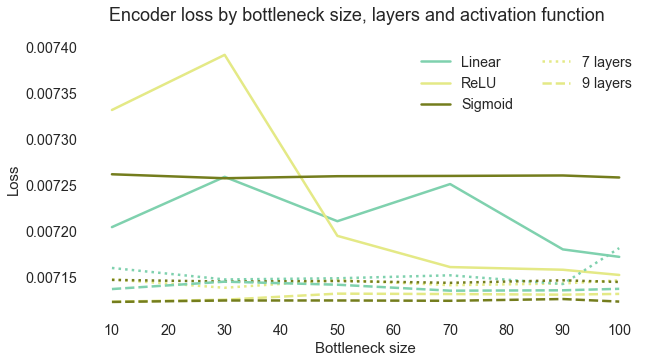

In [395]:
sns.set(rc={"figure.figsize":(10, 5), 'figure.facecolor':'white', 'axes.facecolor': "white"})
sns.despine(offset=10, trim=True)
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
for type, loss in losses.items():
    act_lay = type.split('_l')
    if act_lay[1] == '5' or act_lay[0] == "relu":
        label = type
    else:
        label = '_nolegend_'
    sns.lineplot(x=bottleneck_size, y=loss, color = colors[act_lay[0]],
                 linestyle = lstyle[int(act_lay[1])], label = label)

plt.xticks(list(range(10, 110, 10)))
plt.xlabel("Bottleneck size", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend(labels=["Linear","ReLU", "Sigmoid", "7 layers", '9 layers'],  
           frameon=False, ncol = 2)
plt.suptitle('Encoder loss by bottleneck size, layers and activation function',
            fontsize = 18, horizontalalignment = 'center')

plt.savefig('NN_lay_act_bsize_loss.png', dpi=300)

In [319]:
encoded_bestfit = nn_results['sigmoid_s100_l9'].predict(pd.DataFrame(X_train).append(pd.DataFrame(X_test)))

## 5) Encoded data vs raw data
We can now compare the output of our best model to our raw data. To make this easier, we will use PCA. This will help us reduce the number of dimensions used and could therefore plot the data better.

In [342]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_encoded = pca.fit_transform(encoded_bestfit)
pca_raw = pca.fit_transform(scaler.fit_transform(final_data_pr))

In [366]:
np.corrcoef(pca_encoded[:,0], pca_raw[:,0])

array([[1.        , 0.17443096],
       [0.17443096, 1.        ]])

In [367]:
np.corrcoef(pca_encoded[:,1], pca_raw[:,1])

array([[ 1.        , -0.04433886],
       [-0.04433886,  1.        ]])

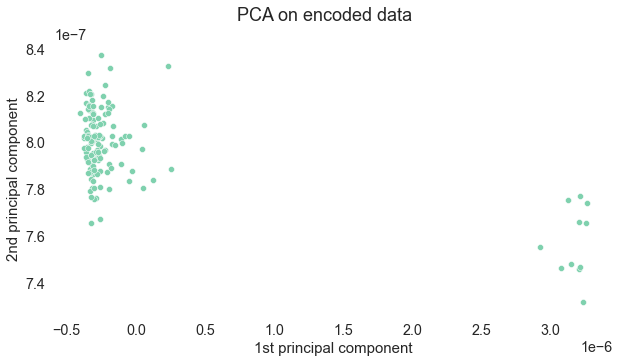

In [401]:
sns.scatterplot(x = pca_encoded[:,0], y = pca_encoded[:,1], color = '#7FD1AE')
plt.xlabel("1st principal component", fontsize = 15)
plt.ylabel("2nd principal component", fontsize = 15)
plt.suptitle('PCA on encoded data',
            fontsize = 18, horizontalalignment = 'center')
plt.savefig('PCA_encoded.pdf', dpi=300)

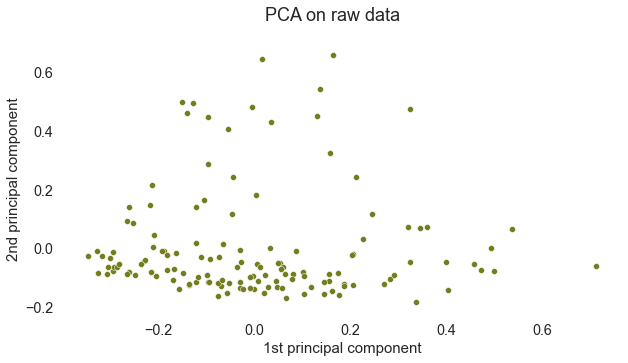

In [406]:
sns.scatterplot(x = pca_raw[:,0], y = pca_raw[:,1], color = "#747D1D")
plt.xlabel("1st principal component", fontsize = 15)
plt.ylabel("2nd principal component", fontsize = 15)
plt.suptitle('PCA on raw data', fontsize = 18)
plt.savefig('PCA_raw.pdf', dpi=300)